In [1]:
# help from https://witestlab.poly.edu/blog/capture-and-decode-fm-radio/
%matplotlib inline
import numpy as np
from rtlsdr import RtlSdr
from scipy import signal
import matplotlib.pyplot as plt
import wave

In [2]:
sdr = RtlSdr()

duration = 30
F_station = int(95.9e6) # 95.9 MHz   MBC 표준 FM
F_offset = 250000

Fc = F_station - F_offset
Rs = int(2.8e6)
N = int(duration * Rs)

# configure device
sdr.set_sample_rate(Rs)
sdr.set_center_freq(Fc)
sdr.set_freq_correction(66)
sdr.set_gain(33.8)

samples = sdr.read_samples(N)

sdr.close()
del(sdr)

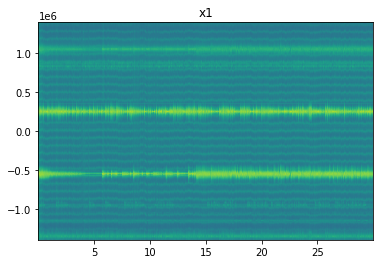

In [3]:
x1 = np.array(samples).astype("complex64")

plt.specgram(x1, NFFT=2048, Fs=Rs, vmin=-140, vmax=-50)

plt.title("x1")
plt.ylim(-Rs/2, Rs/2)
plt.savefig('./figure/x1.png', dpi=200, facecolor='#eeeeee')
plt.show()

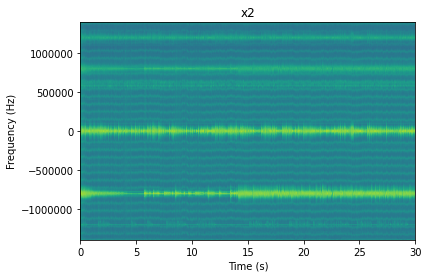

In [4]:
fc1 = np.exp(-1.0j*2.0*np.pi * F_offset/Rs*np.arange(len(x1)))
x2 = x1 * fc1

plt.specgram(x2, NFFT=2048, Fs=Rs, vmin=-140, vmax=-50)
plt.title("x2")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.ylim(-Rs/2, Rs/2)
plt.xlim(0, len(x2)/Rs)
plt.ticklabel_format(style='plain', axis='y')
plt.savefig('./figure/x2.png', dpi=200, facecolor='#eeeeee')
plt.show()

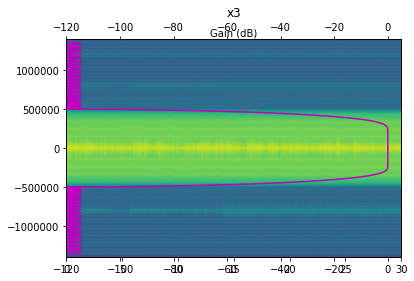

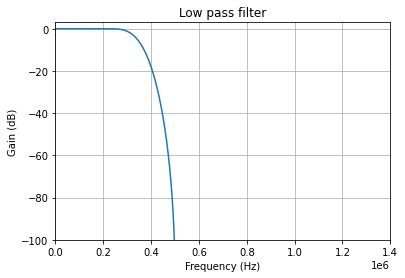

In [5]:
f_bw = 200000

lpf = signal.remez(64, [0, f_bw, f_bw+(Rs/2-f_bw)/4, Rs/2], [1, 0], fs=Rs)
w, h = signal.freqz(lpf, 1, worN=2000)
x3 = signal.lfilter(lpf, 1.0, x2)

plt.specgram(x3, NFFT=2048, Fs=Rs)
plt.title("x3")
plt.ylim(-Rs/2, Rs/2)
plt.xlim(0, len(x3)/Rs)
plt.ticklabel_format(style='plain', axis='y')

ax2 = plt.twiny()
ax2.plot(20*np.log10(np.abs(h)), 0.5*Rs*w/np.pi, 'm')
ax2.set_xlabel('Gain (dB)')
ax2.set_xlim(-120, 5)

ax2 = plt.twiny()
ax2.plot(20*np.log10(np.abs(h)), -0.5*Rs*w/np.pi, 'm')
ax2.set_xlim(-120, 5)

plt.savefig('./figure/x3.png', dpi=200, facecolor='#eeeeee')
plt.show()

plt.plot(0.5*Rs*w/np.pi, 20*np.log10(np.abs(h)))
plt.ylim(-100, 3)
plt.xlim(0, Rs/2)
plt.grid(True)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain (dB)')
plt.title('Low pass filter')
plt.savefig('./figure/lpf.png', dpi=200, facecolor='#eeeeee')
plt.show()

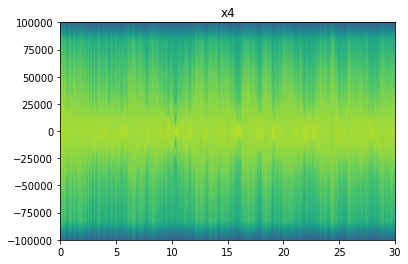

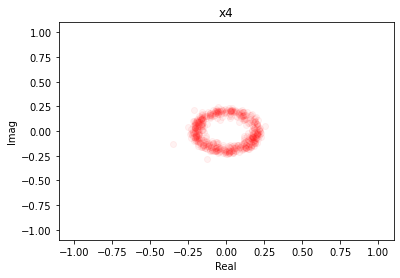

In [6]:
dec_rate = int(Rs / f_bw)
x4 = x3[0::dec_rate]
Fs_y = Rs/dec_rate

f_bw = 200000
dec_rate = int(Rs / f_bw)
x4 = signal.decimate(x2, dec_rate)
Fs_y = Rs/dec_rate

plt.specgram(x4, NFFT=2048, Fs=Fs_y)
plt.title("x4")
plt.ylim(-Fs_y/2, Fs_y/2)
plt.xlim(0, len(x4)/Fs_y)
plt.ticklabel_format(style='plain', axis='y')
plt.savefig('./figure/x4.png', dpi=200, facecolor='#eeeeee')
plt.show()

const_samples = np.random.choice(x4, 500)
plt.scatter(np.real(const_samples), np.imag(const_samples), color="red", alpha=0.05)
plt.title("x4")
plt.xlabel("Real")
plt.xlim(-1.1, 1.1)
plt.ylabel("Imag")
plt.ylim(-1.1, 1.1)
plt.savefig('./figure/constellation .png', dpi=200, facecolor='#eeeeee')
plt.show()

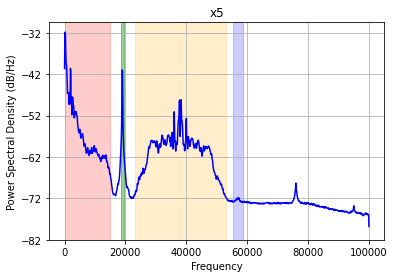

In [7]:
y5 = x4[1:] * np.conj(x4[:-1])
x5 = np.angle(y5)

plt.psd(x5, NFFT=2048, Fs=Fs_y, color="blue")
plt.title("x5")
plt.axvspan(0,             15000,         color="red", alpha=0.2)
plt.axvspan(19000-500,     19000+500,     color="green", alpha=0.4)
plt.axvspan(19000*2-15000, 19000*2+15000, color="orange", alpha=0.2)
plt.axvspan(19000*3-1500,  19000*3+1500,  color="blue", alpha=0.2)
plt.ticklabel_format(style='plain', axis='y')
plt.savefig('./figure/x5 .png', dpi=200, facecolor='#eeeeee')
plt.show()

In [8]:
d = Fs_y * 75e-6
x = np.exp(-1/d)
b = [1-x]
a = [1, -x]
x6 = signal.lfilter(b, a, x5)

In [9]:
audio_freq = 44100.0
dec_audio = int(Fs_y/audio_freq)
Fs_audio = Fs_y / dec_audio

x7 = signal.decimate(x6, dec_audio)

x7 *= 10000 / np.max(np.abs(x7))
x7.astype("int16").tofile("wbfm-mono.raw")

In [10]:
with open("wbfm-mono.raw", 'rb') as opened_pcm_file:
    pcm_data = opened_pcm_file.read();
wav_obj = wave.open('wbfm.wav', 'wb')
wav_obj.setnchannels(1)
wav_obj.setsampwidth(2)
wav_obj.setframerate(44100)
wav_obj.writeframes(pcm_data)
wav_obj.close()